In [1]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
from vega import VegaLite

from histbook import Hist, beside, groupby, below
from histbook import bin as hbin


import zlib
import pickle
import lookup_tools 
import uproot
import awkward
import numpy as np
from dummy_distributions import dummy_jagged_eta_pt
#import cloudpickle

#import zlib

#import weights as weights
#import pickle
#import zlib
#import numpy as np


job_server = ("ifdb02.fnal.gov", 8765)
#job_server = ("dbwebdev.fnal.gov", 8765)
datasets = ["QCD_HT200to300_PUMoriond17_05Feb2018_94X_mcRun2_asymptotic_v2-v1_NANOAODSIM",
            "JetHT_Run2016H_05Feb2018_ver2-v1_NANOAOD",
           "ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8",
           "WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8",
           ]



In [2]:
# Load histograms with lookup_tools
extractor = lookup_tools.extractor()
extractor.add_weight_sets(["testJson * EIDISO_WH_out.histo.json"])
extractor.finalize()
 
evaluator = extractor.make_evaluator()
#let's pickle and zip it
eval_pickle = pickle.dumps(evaluator)
eval_pickle= zlib.compress(eval_pickle)


counts, test_eta, test_pt = dummy_jagged_eta_pt()
 
sf_out = evaluator['testJsonEIDISO_WH/eta_pt_ratio_value'](test_eta, test_pt)
sf_err_out = evaluator['testJsonEIDISO_WH/eta_pt_ratio_error'](test_eta, test_pt)
#print(sf_out)
#print(sf_err_out)

In [3]:
#__worker_class__
import uproot, uproot_methods, awkward, numpy, zlib, pickle

class Worker(object):

    Columns = ["nJet","nMuon","nElectron","Jet.pt", "MET_pt","Electron.pt","Electron.eta","Electron.phi",
               "Electron.dxy", "Electron.dz","Electron.mass", "Electron.pfRelIso03_all", "Electron.mvaSpring16GP_WP90",
               "Muon.pt", "Muon.eta", "Muon.phi", "Muon.mass","Muon.dxy", "Muon.dz", "Muon.pfRelIso04_all"   ]
    
    
    
    
    def run(self, events, job):
        
        # obtain pickled and ziped evaluator, unzip and unpickle
        
        #eval_pickle = job["evaluator"]
        #eval_pickle = zlib.decompress(eval_pickle)
        #evaluator = pickle.loads(eval_pickle)
        electrons_pt = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.pt)
        electrons_eta = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.eta)
        electrons_phi = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.phi)
        electrons_mass = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.mass)


        muons_pt = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.pt)
        muons_eta = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.eta)
        muons_phi = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.phi)
        muons_mass = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.mass)

        
        electrons = uproot_methods.classes.TLorentzVector.TLorentzVectorArray.from_ptetaphim(electrons_pt,electrons_eta,electrons_phi,electrons_mass)
        muons = uproot_methods.classes.TLorentzVector.TLorentzVectorArray.from_ptetaphim(muons_pt,muons_eta, muons_phi, muons_mass)

        
        electrons["dxy"] = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.dxy)
        electrons["dz"] = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.dz)
        electrons["pfRelIso03_all"] = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.pfRelIso03_all)
        electrons["mvaSpring16GP_WP90"] = awkward.JaggedArray.fromcounts(events.Electron.count,events.Electron.mvaSpring16GP_WP90)


        muons["dxy"] = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.dxy)
        muons["dz"] = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.dz)
        muons["pfRelIso04_all"] = awkward.JaggedArray.fromcounts(events.Muon.count,events.Muon.pfRelIso04_all)
       


        #loose lepton selection
            #loose electron selection
        loose_e_selection = (electrons.pt>7)*(abs(electrons.eta)<2.4)*(abs(electrons["dxy"])<0.05)*(abs(electrons["dz"])<0.2)*(electrons["pfRelIso03_all"]<0.4)*(electrons["mvaSpring16GP_WP90"])
        loose_electrons = electrons[loose_e_selection]
      
            #loose muon selection
        loose_m_selection = (muons.pt>5)*(abs(muons.eta)<2.4)*(abs(muons["dxy"])<0.5)*(abs(muons["dz"])<1)*(muons["pfRelIso04_all"]<0.4)
        loose_muons = muons[loose_m_selection]
        
        
        #                                           Histogram variables
        
        e_pt = loose_electrons.pt
        e_pt_flat = numpy.concatenate(e_pt)
        
        m_pt = loose_muons.pt
        m_pt_flat = numpy.concatenate(m_pt)
        
        e_energy = loose_electrons.E
        e_energy_flat = numpy.concatenate(e_energy) # Flattens jagged array
        
        m_energy = loose_muons.E
        m_energy_flat = numpy.concatenate(m_energy)
        
        e_eta = loose_electrons.eta
        e_eta_flat = numpy.concatenate(e_eta)
        
        m_eta = loose_muons.eta
        m_eta_flat = numpy.concatenate(m_eta)
        
        
        #sf_out = evaluator['testJsonEIDISO_WH/eta_pt_ratio_value'](e_eta_flat, e_pt_flat)
        
        weights  = numpy.ones(len(e_energy_flat))
        
        #job.message(str(e_energy_flat))
        #basic_cuts = events.filter((events.nJet >= 2) * (events.Jet.pt[0] > 40))  #etc.. 
        #events = basic_cuts(events)  
        
        
        
        
        
        dataset = dataset = job["dataset"]
        job.fill(dataset=dataset, Electron_pt=e_pt_flat)
        job.fill(dataset=dataset, Muon_pt=m_pt_flat)
        job.fill(dataset=dataset, Electron_E = e_energy_flat,  weight=weights)
        job.fill(dataset=dataset, Muon_E=m_energy_flat)
        job.fill(dataset=dataset, Electron_eta=e_eta_flat)
        job.fill(dataset=dataset, Muon_eta=m_eta_flat)
        #job.fill(dataset=dataset, weight=weight)
        
      
        
        

In [4]:
session = Session(job_server)



electron_pt = Hist(hbin("Electron_pt", 70, 0, 800), groupby("dataset"))
muon_pt = Hist(hbin("Muon_pt", 70, 0, 800), groupby("dataset"))


electron_E = Hist(hbin("Electron_E",70,0,1500),groupby("dataset"), weight="weight")
muon_E     = Hist(hbin("Muon_E",70,0,1500),groupby("dataset"))

electron_eta = Hist(hbin("Electron_eta",50,-2.5,2.5),groupby("dataset"))
muon_eta = Hist(hbin("Muon_eta",50,-2.5,2.5),groupby("dataset"))




disp = below(
    beside(
        electron_pt
            .stack("dataset")
            .area("Electron_pt", width=300, yscale={"type":"log"}),
        muon_pt
            .stack("dataset")
            .area("Muon_pt", width=300, yscale={"type":"log"})
        #nelectrons
         #   .stack("dataset")
          #  .area("nElectron", width=200)
    ),
    beside(
        electron_E
            .stack("dataset")
            .area("Electron_E", width=300, yscale={"type":"log"}),
        muon_E
            .stack("dataset")
            .area("Muon_E", width=300, yscale={"type":"log"})
    ),
    
    beside(
        electron_eta
            .stack("dataset")
            .area("Electron_eta", width=300, yscale={"type":"log"}),
        muon_eta
            .stack("dataset")
            .area("Muon_eta", width=300, yscale={"type":"log"})
    
    )
    
)
    

display = IPythonDisplay(
    disp
)



class Callback:
    
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()
    def on_stream_update(self,nEvents, data):
        for x in data["a"]:
            print x
    def on_message(self,workerId, nEvents, message):
        print message
    def on_exception(self,workerId, info):
        print info


QCD_HT200to300_PUMoriond17_05Feb2018_94X_mcRun2_asymptotic_v2-v1_NANOAODSIM   0.000 M events,   0.000 M events/sec
JetHT_Run2016H_05Feb2018_ver2-v1_NANOAOD                                 0.000 M events,   0.000 M events/sec
ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8                   3.056 M events,   0.108 M events/sec
WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8                           2.493 M events,   0.101 M events/sec


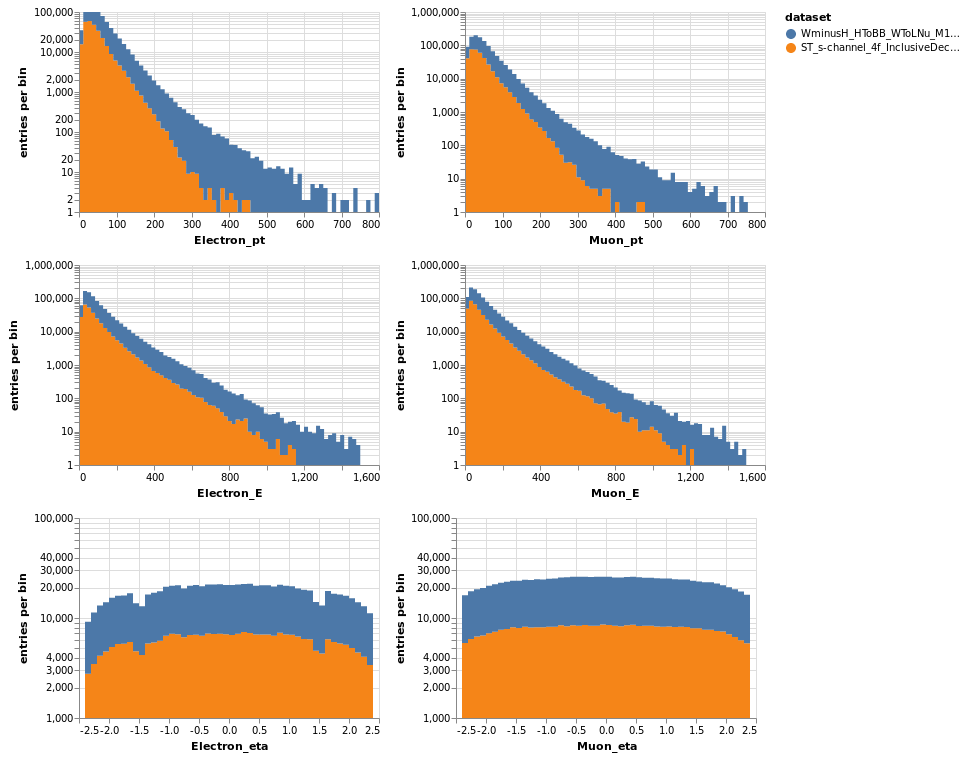

In [5]:
display.init()
callback = Callback(display)
for dataset_name in datasets:
    job = session.createJob(dataset_name, 
        user_callback=callback,
        user_params = {"dataset":dataset_name,"evaluator":eval_pickle},
        histograms=[electron_pt,muon_pt,electron_E, muon_E, electron_eta, muon_eta]
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset_name, float(nevents)/1000000, nevents/runtime/1000000)

disp.to(VegaLite)